## **Modules and Settings**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import  StandardScaler,OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA


## **Data Load**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
original_data = pd.read_csv("/content/drive/MyDrive/Kaggle Data Sets/Stori Data Challenge 2021 ( (1) (1) (3).csv")

## **Data Clean and Validation**

In [ ]:
# I did this to validate the data types
original_data.dtypes 

Unnamed: 0                            int64
cust_id                              object
activated_date                       object
last_payment_date                    object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
fraud                                 int64
dtype: object

Observations:

- The first and second column is unnecessary, so we can delete them
- The columns "activated_date" and "last_payment_date" must be converted to a date data type
- Fraud data type needs to be string

In [ ]:
#Removing Unnecessary Columns
original_data = original_data.drop(["Unnamed: 0"],axis=1)

#Converting to Date Columns
original_data['activated_date'] = pd.to_datetime(original_data['activated_date'])
original_data['last_payment_date'] = pd.to_datetime(original_data['last_payment_date'])

#Converting Fraud in String
original_data['fraud']= original_data['fraud'].astype('string')


In [ ]:
# This will be used in question 3, with this set I will create the new data frames for the models
data_model = original_data.copy()

In [ ]:
# I did this to check null values
original_data.isnull().sum()

cust_id                               0
activated_date                       13
last_payment_date                     9
balance                               2
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                        112
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    321
prc_full_payment                      0
tenure                                0
fraud                                 0
dtype: int64

In [ ]:
# To check how many we are losing removing Nans
old_shape = original_data.shape
original_data = original_data.dropna(axis=0,how="any")
new_shape= original_data.shape
new_shape[0]/old_shape[0]

0.9493854748603352

We can see that we lost a bit more than 5%, is consider a low value, so we can proceed without an imputation technique. I decided this because I think that if the sample is large, eliminate values ​​is better than make estimation errors

## **Exploratory Data Analysis**
I graphed the variables to get an idea of the data form and answer question 1

In [ ]:
numeric_columns = original_data.select_dtypes(include=np.number).columns.tolist()
classif_columns = ["fraud"]

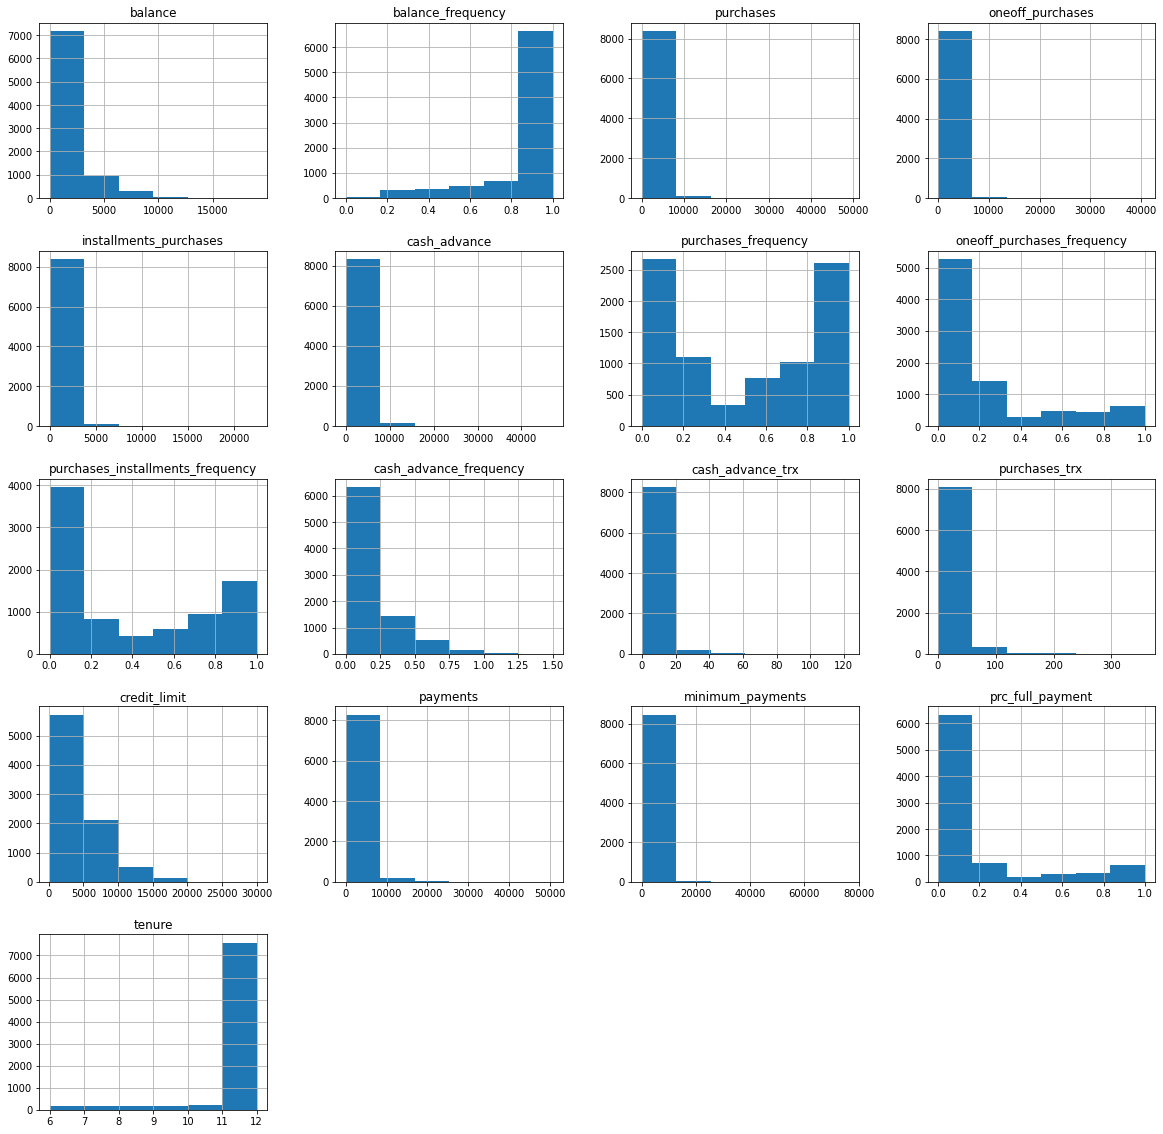

In [ ]:
k = int(np.ceil(1 + np.log2(new_shape[1]))) # Using Sturges Rule to determine the number of bins
original_data[numeric_columns].hist(bins = k, figsize=(20,20))
plt.show()

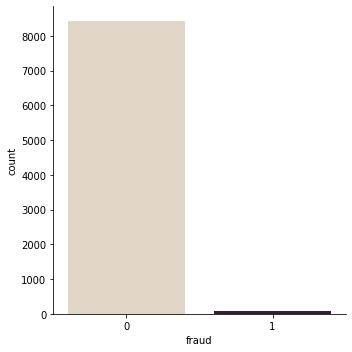

In [ ]:
sns.catplot(x="fraud", kind="count", palette="ch:.25", data=original_data)

In [ ]:
original_data['fraud'].value_counts() #We can see that 2 Nan were fraud

0    8429
1      68
Name: fraud, dtype: Int64

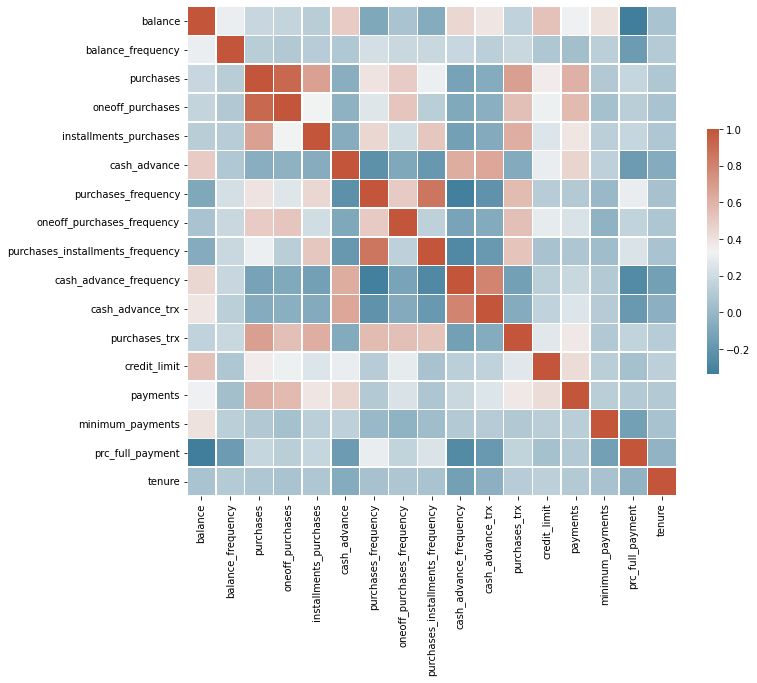

In [ ]:
corr = original_data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

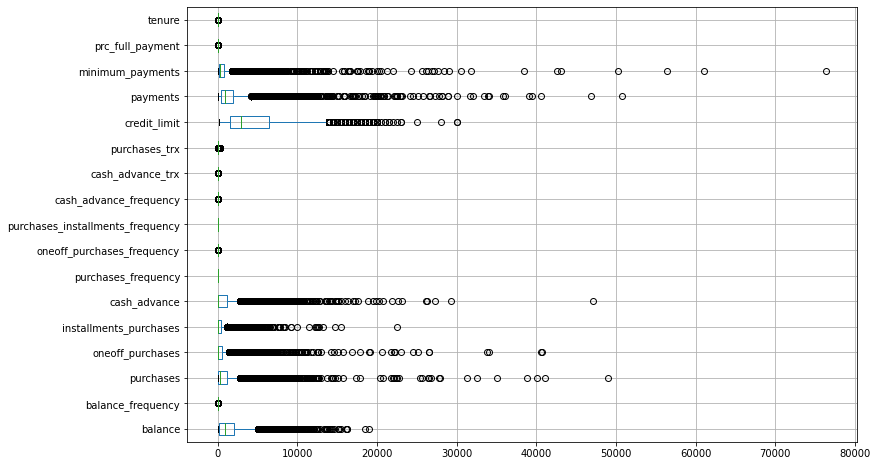

In [ ]:
plt.figure(figsize=(12,8))
original_data.boxplot(vert=False)
plt.show()

## **ANSWER QUESTION 1**
#### **1.1 Plot an histogram of the balance amount for all the customers.**

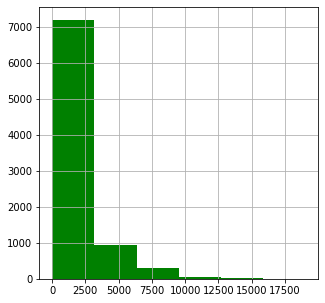

In [ ]:
original_data["balance"].hist(bins = k, figsize=(5,5),color="green")
plt.show()

#### **1.2 Report any structure you find and any hypotheses you have about that structure.**

- Most of the quantitative categories have kurtosis and high variance, it will be necessary standarize them
- Most of the variables appears to follow an exponential distribution except: tenure, balance_frequency and purshases_frequency
-  Most of the variables show a low correlation between them and in those that have, this correlation is negative.
- The number of outliers is too high its necessary clear them
- I think It will be interesting if  I take the month of the "activate_date" and "last_payment_date" to create new categorical variables.
- The number of frauds is too slow, if we lost too many values in this category cleanning the ouliers, it could be better keep the outliers.


#### **1.3 Report mean and median balance, grouped by year and month of activated_date.**

In [ ]:
# I made new columns in order to get easily the year and month
original_data["activated_date_year"] = original_data["activated_date"].dt.year
original_data["activated_date_month"]= original_data["activated_date"].dt.month

#This is the group with mean
grouped_data_mean = original_data.groupby(["activated_date_year","activated_date_month"])
grouped_data_mean.aggregate(
    {
        "balance":np.mean
    }
)

balance
activated_date_year activated_date_month             
2019                10                    2548.794248
                    11                    1890.539524
                    12                    2051.316984
2020                1                     1864.259536
                    2                     1784.641287
                    3                     1590.094278
                    4                     1540.150147
                    5                     1249.460309
                    6                      971.212562
                    7                      664.835110

In [ ]:
#This is the group with median
grouped_data_median = original_data.groupby(["activated_date_year","activated_date_month"])
grouped_data_mean.aggregate(
    {
        "balance":np.median
    }
)

balance
activated_date_year activated_date_month             
2019                10                    1545.598011
                    11                    1107.961644
                    12                    1193.351573
2020                1                     1180.961924
                    2                     1018.880453
                    3                      894.357857
                    4                      969.583332
                    5                      779.431874
                    6                      518.894713
                    7                      251.144969

## **ANSWER QUESTION 2**
#### **2.1 Report in a table the following information for customers who activated their account and made their last payment during 2020: cust_id (excluding letters), activated_date (in format YYYY-MM), last_payment_date (in format YYYY-MM-DD), cash_advance, credit_limit, and a calculated field of cash_advance as a percentage of credit_limit.**

In [ ]:
# I made this column in order to get easily the year 
original_data["last_payment_date_year"] = original_data["last_payment_date"].dt.year

# This part is the filter to select 2020 year
data2020 = original_data.loc[(original_data["last_payment_date_year"]==2020) & (original_data["activated_date_year"]==2020)]

# I convert id into a string to drop the letters in the Id column
data2020["cust_id"]= data2020["cust_id"].astype('string')

#This new column is to  get the percentage of credit_limit.
data2020["cash_advance_percentage"]= (data2020["cash_advance"]*100)/data2020["credit_limit"]

#Warning is not very important c;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#This part shows the answer
data2020.aggregate(
    {
        "cust_id": lambda x: x.str[1:],
        "activated_date": lambda x: str(x.year) + '-' + str(x.month),
        "last_payment_date": lambda x: x,
        "cash_advance": lambda x:x,
        "credit_limit": lambda x:x,
        "cash_advance_percentage":lambda x:x
    }
)

,cust_id,activated_date,last_payment_date,cash_advance,credit_limit,cash_advance_percentage
2633,12709,2020-1,2020-05-08,2431.292076,8000.0,30.391151
2634,12710,2020-1,2020-05-26,0.000000,2000.0,0.000000
2635,12712,2020-1,2020-10-20,0.000000,3000.0,0.000000
2636,12713,2020-1,2020-08-22,0.000000,9000.0,0.000000
2637,12714,2020-1,2020-04-26,78.763096,1500.0,5.250873
...,...,...,...,...,...,...
8943,19184,2020-7,2020-08-10,0.000000,500.0,0.000000
8945,19186,2020-7,2020-11-03,0.000000,1000.0,0.000000
8947,19188,2020-7,2020-06-03,0.000000,1000.0,0.000000
8948,19189,2020-7,2020-07-19,36.558778,500.0,7.311756


## **Question 3**
3.1 Build a predictive model for fraud.


In [ ]:
# Set Type of variables
ls_cont = data_model.select_dtypes(include=np.number).columns.tolist()
ls_disc = ["activated_date_month","last_payment_date_month"] 
target = "fraud"

**Cleaning Outliers and Null Values**

Before drop the outliers I will check how many data is losing when we do this

In [ ]:
data_model_clean = data_model.copy().dropna(axis=0,how="any") 
shape_o = data_model_clean.shape

In [ ]:
dc_perc = {feature: data_model_clean[feature].quantile(0.99) for feature in ls_cont}
for feat, perc in dc_perc.items():
    data_model_clean = data_model_clean[data_model_clean[feat] <= perc]

shape_a = data_model_clean.shape


In [ ]:
shape_a[0]/shape_o[0]

0.7236671766505826

We are losing too many data, I will try a model with outliers and if it fail... I will use the data_model_clean set

**Feature Engineering**

In [ ]:
#Create New columns using the month of activate date and last payment date
data_model["activated_date_month"]= data_model["activated_date"].dt.month.astype('string')
data_model["last_payment_date_month"]= data_model["last_payment_date"].dt.month.astype('string')

#Now we can drop the columns id and the date type columns
data_model = data_model.drop(["cust_id","activated_date","last_payment_date"],axis=1)


**Second EDA and Choosing Model**

I tried to run the pairplot between all variables but my internet collection crashed, so I separated the numeric variables in groups of 4 and 5 to see its form and chose what model could function better

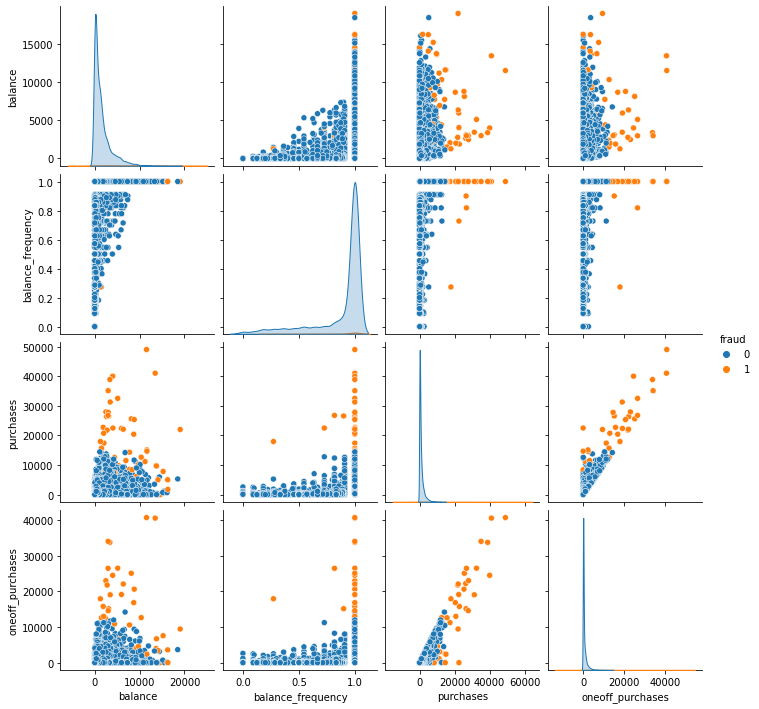

In [ ]:
plotf = data_model[ls_cont[0:4] + ["fraud"]]
sns.pairplot(plotf,hue="fraud")
plt.show()

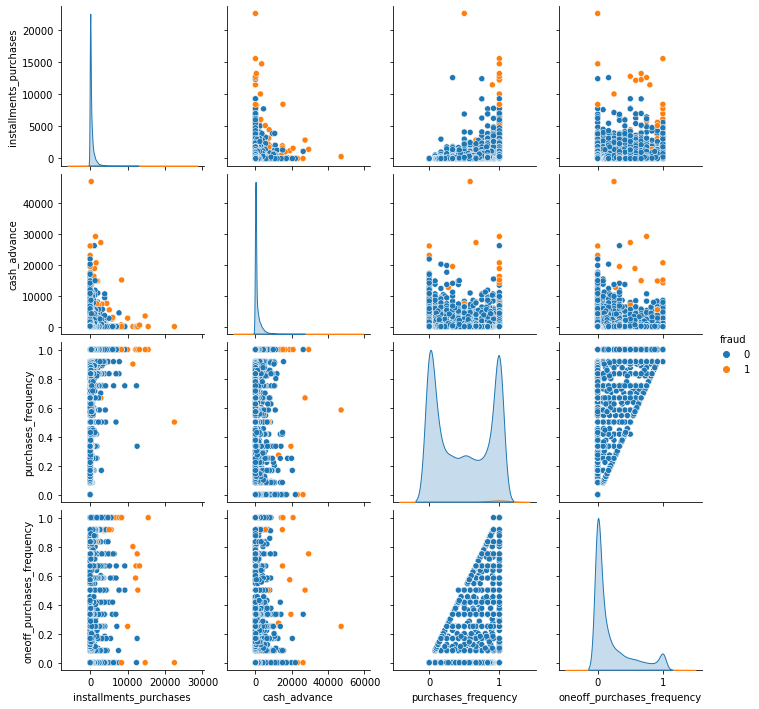

In [ ]:
plotf = data_model[ls_cont[4:8] + ["fraud"]]
sns.pairplot(plotf,hue="fraud")
plt.show()

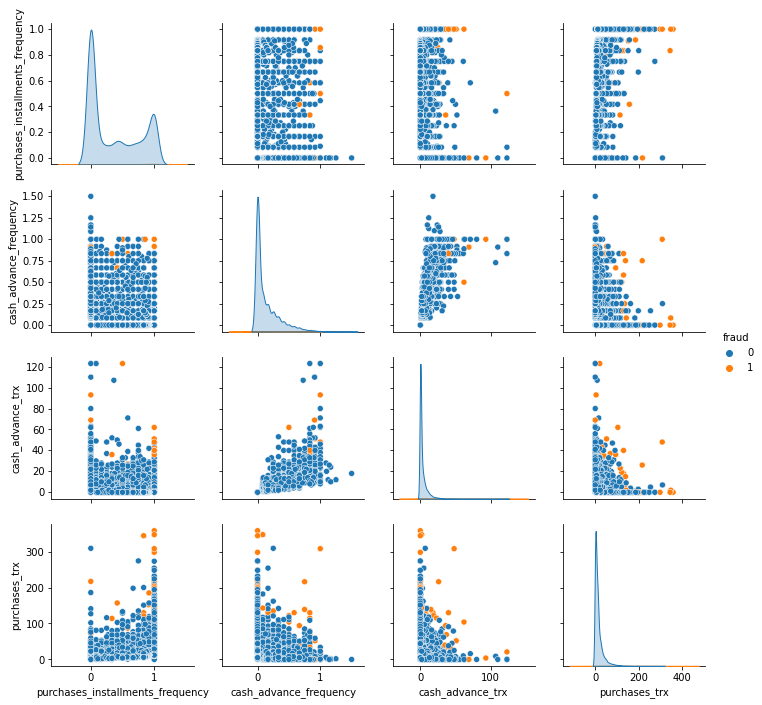

In [ ]:
plotf = data_model[ls_cont[8:12] + ["fraud"]]
sns.pairplot(plotf,hue="fraud")
plt.show()

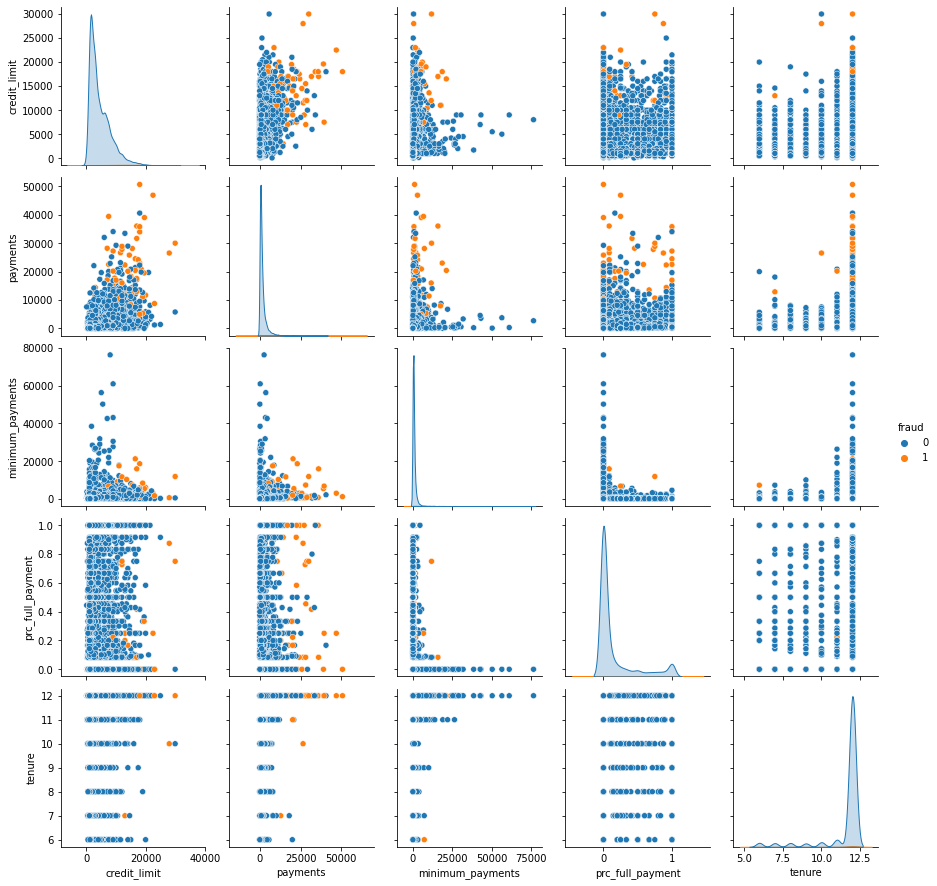

In [ ]:
plotf = data_model[ls_cont[12:17] + ["fraud"]]
sns.pairplot(plotf,hue="fraud")
plt.show()

Observations:
- The first plot showed that a logistic regression could be good enough to classified the fraud, but in the last plots the data seemed unclear.
- I will tried a logistic regression and a tree classifier model.

In [ ]:
# I create another data set to do the first try
data_model_without_na = data_model.copy().dropna(axis=0,how="any") 

**DATA PREPROCESSING**


In [ ]:
# Here I choose the columns
X = data_model_without_na[[x for x in data_model_without_na.columns if x!= target]]
y = data_model_without_na[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=3)

In [ ]:
# This part is to see the fraud values, I think is important because the sample of 1 is low
a = y.value_counts()
b = y_train.value_counts()
c = y_test.value_counts()
print(f"The Fraud Values are: \n{a} ")
print(f"The Fraud Values For Train are: \n{b} ")
print(f"The Fraud Values For Test are: \n{c} ")

The Fraud Values are: 
0    8429
1      68
Name: fraud, dtype: Int64 
The Fraud Values For Train are: 
0    6743
1      54
Name: fraud, dtype: Int64 
The Fraud Values For Test are: 
0    1686
1      14
Name: fraud, dtype: Int64 


**Create Pipelines**

In [ ]:
disc_pipe = Pipeline([
      ("Encoder", OneHotEncoder(handle_unknown="ignore"))
]) #This part is to create dummy variables with the months

cont_pipe = Pipeline([
      ("Scaler", StandardScaler())
])# In this part we are decreasing the variance

preprocessing_pipe = ColumnTransformer([
      ("disc_pre",disc_pipe,ls_disc),
      ("cont_pre",cont_pipe,ls_cont)
]) #This part is for processing the columns


In [ ]:
#Here I will transform
X_train = preprocessing_pipe.fit_transform(X_train)
X_test  = preprocessing_pipe.transform(X_test)

## **Logistic Regression**

In [ ]:
LR = LogisticRegression(max_iter=3000) # I set 3000 iterations to see what happen
LR.fit(X_train,y_train.values.ravel())


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = LR.predict(X_test)

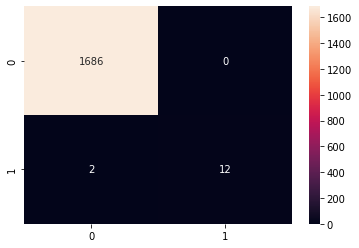

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
score = LR.score(X_train, y_train)
print(f"Score: {score}")
ls_scores = cross_val_score(X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="roc_auc", estimator=LR)
print(f"Val_Score: {ls_scores}")
# The sample is being important

Score: 0.9970575253788436
Val_Score: [0.78232503 0.99781002 0.87790857 0.97766003]


## **Decision Tree Classifier**

In [ ]:
DTC = DecisionTreeClassifier(criterion="entropy") # I chose entropy because this would classified better based on the plots
DTC.fit(X_train,y_train.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred_tree = DTC.predict(X_test)

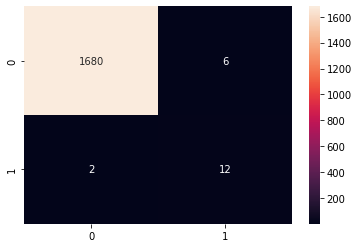

In [ ]:
cm_tree = confusion_matrix(y_test,y_pred_tree)
sns.heatmap(cm_tree,annot=True,fmt="d")

In [ ]:
score_tree = DTC.score(X_train, y_train)
print(f"Score: {score_tree}")
ls_scores_tree = cross_val_score(X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="roc_auc", estimator=DTC)
print(f"Val_Score: {ls_scores_tree}")
# The sample in this model is still significant

Score: 1.0
Val_Score: [0.74940688 0.80383703 0.80650607 0.71280203]


Observations:
- The overfitting is too high in both models, in order to answer the next question and decrease the overfitting I will try a Kbest techinque with 5 the best predictors.

- I think is necessary increase the test size, because there few values with 1 in the test part

## **Question 3**
**3.2 What explanatory variable was the most powerful predictor for fraud?**

I will make a new data frame with all the variables (including the dummies) and I will plot them

In [ ]:
# This function allow us to create the dummies, I decided to do this like this because I wanted a total control with my code
def create_dummies(df,varname):
  dummy = pd.get_dummies(df[varname],prefix=varname)
  df = df.drop(varname,axis=1)
  df = pd.concat([df,dummy],axis=1)
  return df
  
for i in ls_disc:
    data_model_without_na= create_dummies(data_model_without_na,i)

In [ ]:
# In this Part We applied the Kbest
xp = data_model_without_na[[x for x in data_model_without_na.columns if x!= target]]
yp = data_model_without_na[target]
kb = SelectKBest(k="all", score_func=f_classif)

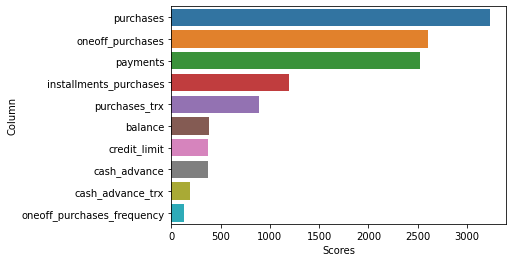

In [ ]:
# Here we extract the scores of the fitting
fit = kb.fit(xp, yp.values.ravel())
index = np.argsort(fit.scores_)[::-1]
features = [] # These list are using to store the scores and features
scores = []
for i in range(len(index)):
    features.append(data_model_without_na.columns[index[i]])
    scores.append(fit.scores_[[index[i]][0]]) #In this part I am store the scores and features

# This dataframe is used to create a better Plot
Best= {'Column': features, 'Scores': scores }  
df = pd.DataFrame(Best)  
Best10= {'Column': features[0:10], 'Scores': scores[0:10] }  
df10 = pd.DataFrame(Best10)  
# Here we plot the Data Frame
sns.barplot(x='Scores',y='Column',data=df10,orient="h")
plt.show()

The most powerful variable is "Purchases"

### **IMPROVING THE MODELS**

I saw that the categorical variables that I created did not work, I will use only cuantitative columns and I will the Data Model Clean Set, this set is clear of Nans and Outliers so the results would be better





In [ ]:
# Here I am Select The columns
X = data_model_clean[[x for x in data_model_clean.columns if x!= target]]
y = data_model_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4,random_state=3) 
# I increase the test Size in order to decrease the overfitting

In [ ]:
a2 = y.value_counts()
b2 = y_train.value_counts()
c2 = y_test.value_counts()
print(f"The Fraud Values are: \n{a2} ")
print(f"The Fraud Values For Train are: \n{b2} ")
print(f"The Fraud Values For Test are: \n{c2} ")

The Fraud Values are: 
0    6144
1       5
Name: fraud, dtype: Int64 
The Fraud Values For Train are: 
0    3688
1       1
Name: fraud, dtype: Int64 
The Fraud Values For Test are: 
0    2456
1       4
Name: fraud, dtype: Int64 


We can see something too bad... Almost all the outliers points have committed fraud. I will try the kbest with outliers because we need a large sample of data to train and test

In [ ]:
# Here I am Select The columns I create other Data frame beacuse the last ones changed
data_model_pro = data_model[ls_cont+[target]].dropna()
X = data_model_pro[[x for x in data_model_clean.columns if x!= target]]
y = data_model_pro[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4,random_state=3)

In [ ]:
a3 = y.value_counts()
b3 = y_train.value_counts()
c3 = y_test.value_counts()
print(f"The Fraud Values are: \n{a3} ")
print(f"The Fraud Values For Train are: \n{b3} ")
print(f"The Fraud Values For Test are: \n{c3} ")

The Fraud Values are: 
0    8449
1      68
Name: fraud, dtype: Int64 
The Fraud Values For Train are: 
0    5068
1      42
Name: fraud, dtype: Int64 
The Fraud Values For Test are: 
0    3381
1      26
Name: fraud, dtype: Int64 


**Create Pipelines**

In [ ]:
cont_pipe = Pipeline([     
      ("5 best",SelectKBest(k=5, score_func=f_classif)),     # I am choosing the best 5 predictors 
      ("Scaler", StandardScaler()), # This is decreasing the variance
      ("PCA",PCA()) # I also applied PCA to get better results
])

preprocessing_pipe = ColumnTransformer([
      ("cont_pre",cont_pipe,ls_cont)
])

In [ ]:
X_train = preprocessing_pipe.fit_transform(X_train,y_train)
X_test  = preprocessing_pipe.transform(X_test)

**Logistic Regression 5 BEST**

In [ ]:
LR_best = LogisticRegression(max_iter=2000)
LR_best.fit(X_train,y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = LR_best.predict(X_test)

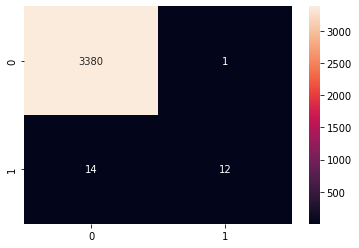

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
score = LR_best.score(X_train, y_train)
print(f"Score: {score}")
ls_scores = cross_val_score(X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="roc_auc", estimator=LR_best)
print(f"Val_Score: {ls_scores}")
# The model is not good enough

Score: 0.9951076320939335
Val_Score: [0.93197962 0.97976609 0.91152328 0.96740331]


**Decision Tree Classifier 5 Best**

In [ ]:
DTC_best = DecisionTreeClassifier(criterion="entropy")
DTC_best.fit(X_train,y_train.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred_tree = DTC_best.predict(X_test)

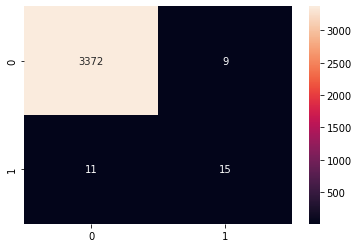

In [ ]:
cm_tree = confusion_matrix(y_test,y_pred_tree)
sns.heatmap(cm_tree,annot=True,fmt="d")

In [ ]:
score_tree = DTC_best.score(X_train, y_train)
print(f"Score: {score_tree}")
ls_scores_tree = cross_val_score(X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="roc_auc", estimator=DTC_best)
print(f"Val_Score: {ls_scores_tree}")
#This seems better C;

Score: 1.0
Val_Score: [0.72372103 0.7256942  0.74842147 0.7476322 ]


**Conclusions**
- The Sample result very important in both models, although we try with the best 5 predictors the logistic model is still overfitting, I think the decision tree clasifier model could function better with a large sample of data, because in the cross validation the overfitting dissapear.